In [25]:
from IPython.display import display_latex
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import Number
#sympy.init_session()
import scipy
from scipy.optimize import fsolve, root
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize
from sklearn import tree


## Exercise 2.1

### 2.1.a

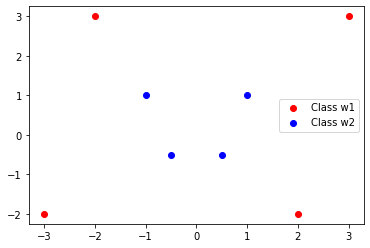

Not linearly separable


array([[ 1.        ,  3.        ,  3.        ,  4.33333333],
       [ 1.        ,  2.        , -2.        ,  1.        ],
       [ 1.        , -3.        , -2.        ,  2.66666667],
       [ 1.        , -2.        ,  3.        ,  2.66666667],
       [ 1.        ,  1.        ,  1.        , -1.        ],
       [ 1.        ,  0.5       , -0.5       , -1.5       ],
       [ 1.        , -0.5       , -0.5       , -1.5       ],
       [ 1.        , -1.        ,  1.        , -1.        ]])

In [26]:
X_test = np.array([[3, 3], [2, -2], [-3, -2], [-2, 3],
        [1, 1], [0.5, -0.5], [-0.5, -0.5], [-1, 1]])

y_test = np.array([-1, -1, -1, -1, 
           1, 1, 1, 1])

# 2.1.a
w1 = [plt.scatter(x[0], x[1], color='red') for x, y in zip(X_test, y_test) if y == -1]
w2 = [plt.scatter(x[0], x[1], color='blue') for x, y in zip(X_test, y_test) if y == 1]

plt.legend([w1[0], w2[0]], ['Class w1', 'Class w2'])
plt.show()

print("Not linearly separable")

def phi_2(x):
    return [1, x[0], x[1], (x[0]**2 + x[1]**2 - 5)/3]

X_test_4d = np.array([phi_2(x) for x in X_test])
X_test_4d

### 2.1.b

In [27]:
def dot_product(a, b):
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

def show_equations(func, variables):
    derivatives = [sympy.diff(func, v) for v in variables]
    equations = [round_expr(sympy.Eq(d, 0), 2) for d in derivatives]
    
    print("The equations for the optimization are:")
    for eq in equations:
       display_latex(eq)

weights = [sympy.symbols('w%d' % i) for i in range(len(X_test_4d[0]))]
lagrange_coeffs = [sympy.symbols('a%d' % i) for i in range(len(y_test))]

# General form
print("The objective function L(w, a) is:")
obj_func = sum(w**2 for w in weights[1:]) / 2 - \
    sum(lagrange_coeffs[i] * (y_test[i] * dot_product(weights, X_test_4d[i]) - 1) for i in range(len(y_test)))

display_latex(obj_func)
show_equations(obj_func, weights)

# Objective function for lagrange multipliers
print("The objective function L(a) is:")
obj_func_lagrange = sum(lagrange_coeffs) - \
    1/2 * sum(sum(a_k * a_j * z_k * z_j * dot_product(y_k, y_j) for a_j, z_j, y_j in zip(lagrange_coeffs, y_test, X_test_4d)) for a_k, z_k, y_k in zip(lagrange_coeffs, y_test, X_test_4d))

display_latex(obj_func_lagrange)
display_latex(show_equations(obj_func_lagrange, lagrange_coeffs))

The objective function L(w, a) is:


The equations for the optimization are:


The objective function L(a) is:


The equations for the optimization are:


In [28]:
def neg_lagrange_dual(alpha, y, z):
    lagrange_sum = sum(alpha)
    double_sum = sum(sum(a_k * a_j * z_k * z_j * dot_product(y_k, y_j) for a_j, z_j, y_j in zip(alpha, z, y)) for a_k, z_k, y_k in zip(alpha, z, y))
    return 1/2 * double_sum - lagrange_sum


def optimize_alpha(x, z, C):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(z, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(neg_lagrange_dual, alpha_0, args = (x, z), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha

print("The Lagrange multipliers are:")
alphas = optimize_alpha(X_test_4d, y_test, 1e5)
for i, alpha in enumerate(alphas): print(f"a_{i} = {alpha:.4f}")

The Lagrange multipliers are:
a_0 = 0.0000
a_1 = 0.1614
a_2 = 0.0000
a_3 = 0.0855
a_4 = 0.1643
a_5 = 0.0398
a_6 = 0.0208
a_7 = 0.0220


### 2.1.c

In [29]:
def calc_weights(x, z, alpha):
    return sum(a_k * z_k * y_k for a_k, z_k, y_k in zip(alpha, z, x))

print("The weights are:")
weights = calc_weights(X_test_4d, y_test, alphas)
for i, weight in enumerate(weights): print(f"w_{i} = {weight:.4f}")
#print(weights)
print()

print("The values of z_k * w * y_k are:")
for z_k, y_k in zip(y_test, X_test_4d):
    print(f"{z_k * dot_product(weights, y_k):.4f}")

The weights are:
w_0 = -0.0000
w_1 = -0.0000
w_2 = 0.2222
w_3 = -0.6667

The values of z_k * w * y_k are:
2.2222
1.1111
2.2222
1.1111
0.8889
0.8889
0.8889
0.8889


### 2.1.d

In [30]:
def get_margin(alpha, t, x, w, C):
    ZERO = 1e-6
    C_numeric = C-ZERO
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > ZERO)&(alpha < C_numeric))[0]
    w0 = 0.0
    for s in ind_sv:
        w0 = w0 + t[s] - np.dot(x[s, :], w)
    # Take the average    
    w0 = w0 / len(ind_sv)
    return w0

b = get_margin(alphas, y_test, X_test_4d, weights, 1e5)
print(b)

0.11111123660548698


### 2.1.e

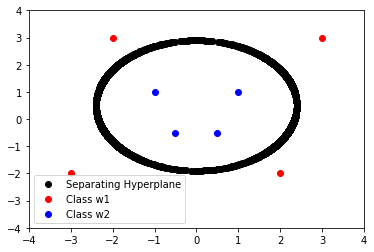

In [32]:
def classifier(x):
    return [np.dot(weights, phi_2(x)) + b, 0]

def get_hyperplane(w, w0):
    x1 = np.linspace(-1, 1, 100)
    x2 = np.linspace(-1, 1, 100)
    xx1, xx2 = np.meshgrid(x1, x2)

    roots = []
    for x, y in zip(xx1.ravel(), xx2.ravel()):
        sol = fsolve(classifier, [x, y])
        roots.append(sol)
    x_roots = np.array([r[0] for r in roots])
    y_roots = np.array([r[1] for r in roots])
    return plt.scatter(x_roots, y_roots, color='black')

g = get_hyperplane(weights, b)
w1 = [plt.scatter(x[0], x[1], color='red') for x, y in zip(X_test, y_test) if y == -1]
w2 = [plt.scatter(x[0], x[1], color='blue') for x, y in zip(X_test, y_test) if y == 1]

plt.legend([g, w1[0], w2[0]], ['Separating Hyperplane', 'Class w1', 'Class w2'])
lim = (-4, 4)
plt.xlim(lim)
plt.ylim(lim)
plt.show()

In [44]:
x_sym = [sympy.symbols('x%d' % i) for i in [1, 2]]
display_latex(classifier(x_sym)[0])
display_latex(round_expr(classifier(x_sym)[0], 2))

### 2.1.st

In [ ]:
def support_vectors(X, alphas):
    ZERO = 1e-6
    return [x for x,a in zip(X, alphas) if a > ZERO]
    
print(support_vectors(X_test, alphas))         

[array([ 2., -2.]), array([-2.,  3.]), array([1., 1.]), array([ 0.5, -0.5]), array([-0.5, -0.5]), array([-1.,  1.])]


### 2.1.z

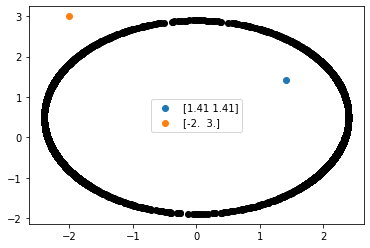

In [49]:
points = [[np.sqrt(2), np.sqrt(2)], [-2, 3]]

get_hyperplane(weights, b)
points_rounded = np.round(points, decimals=2)
for x in points_rounded:
    plt.scatter(x[0], x[1], label=str(x))
plt.legend()
plt.show()

## Exercise 2.3

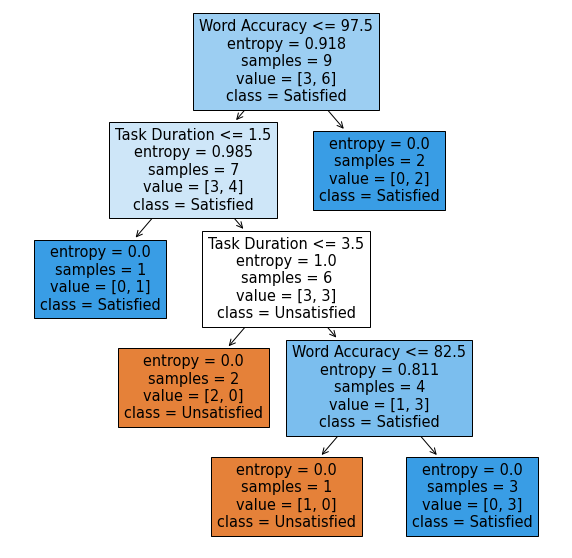

In [ ]:
filename = 'cart_data.txt'
with open(filename, 'r') as f:
    lines = f.readlines()

# Encode unique list elemens using integers
def encoder(l):
    return {e:i for i,e in enumerate(sorted(set(l)))}

def encode_by_columns(l):
    encoded_l = []
    for i in range(len(l[0])):
        column = [row[i] for row in l]
        column_encoder = encoder(column)
        column_int = [column_encoder[x] for x in column]
        encoded_l.append(column_int)
    return list(np.array(encoded_l).transpose())


data = [line.split() for line in lines]

y_train = [1 if x[0] == 'Y' else 0 for x in data]
#y_train_encoder = encoder(y_train)
#y_train_int = [y_train_encoder[y] for y in y_train]
#print(y_train_int)

X_train = [[int(x[1]), 1 if x[2] == 'Y' else 0, int(x[3])] for x in data]
#X_train_int = encode_by_columns(X_train)
#print(X_train_int)

clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train, y_train)

# Create subplots  
fig, ax = plt.subplots(1, figsize=(10, 10))
tree.plot_tree( clf, 
                class_names=['Unsatisfied', 'Satisfied'], 
                feature_names=['Word Accuracy', 'Task Completion', 'Task Duration'], 
                filled=True, 
                ax=ax)

pass

## Exercise 2.4

In [7]:
filename = 'MLR.data'
with open(filename, 'r') as f:
    lines = f.readlines()

split_lines = [line.split() for line in lines]
data = [[float(l[0]), float(l[1]), int(l[2])] for l in split_lines]

X_train = np.array([d[:2] for d in data])
y_train = np.array([d[2] for d in data])
nclasses = np.unique(y_train).size

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from numpy import dot, multiply, squeeze, zeros, ones, reshape, array, identity
import numpy as np
from mlxtend.plotting import plot_decision_regions

        
def stable_softmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator / denominator
    
    return softmax

def softmax(W, X, K):
    N = X.shape[0]
    M = X.shape[1]
    softmax_all = zeros((N,K))
    for i,xn in enumerate(X):
        xn = reshape(xn, (M,1))  # M x 1
        A = []
        for k in range(K):
            a_nk = squeeze(dot( reshape(W[k], (1,M)), xn )) # scalar
            A.append(a_nk)
        softmax_all[i,:] = reshape(array(stable_softmax(A)), (1,K))    
    return softmax_all  # N x K
           

class IRLS(BaseEstimator, ClassifierMixin):
    def __init__(self, nclasses=2, maxiter=10):
        self.W = None
        self.nclasses = nclasses
        self.maxiter = maxiter

    def fit(self, X, t):
        K = self.nclasses
        X_t = X.transpose()

        N = X.shape[0] # n_samples
        M = X.shape[1] # n_features
        I = np.identity(K)  # K x K

        # 1-of-K coding scheme for target values
        T = zeros((N,K))   # N x K
        for i,k in enumerate(t):
            T[i][k] = 1

        # Initialize w, grad, hessian
        self.W = zeros(shape=(K,M))        # K x M
        grad = ones(shape=(K,M))      # K x M 
        H = ones(shape=(K*M,K*M))     # K*M x K*M

        for iteration in range(self.maxiter):

            # Y = softmax for all n,k
            Y = softmax(self.W, X, K)  # N x K

            # gradient of cross-entropy error function
            grad = dot( X_t, Y - T ).transpose()   # K x M

            # Hessian Matrix: K*M x K*M
            for k in range(K):
                for j in range(K):
                    Ikj = I[k][j]
                    # Diagonal R
                    R = zeros((N,N)) 
                    for n in range(N):
                        R[n][n] = Y[n][k] * (Ikj - Y[n][j])

                    H[k*M:k*M+M, j*M:j*M+M] = dot( dot(X_t, R), X )  # M x M                

            # Newton-Raphson update
            self.W = reshape(self.W, (K*M,1))
            grad = reshape(grad, (K*M,1))
            Wnew = self.W - dot( np.linalg.pinv(H), grad )

            # keep preferred dimensions 
            grad = reshape(grad, (K,M))
            self.W = reshape(Wnew, (K,M))

            continue
        
        return self
      
    def predict(self, X):
        # Logistic Regression predict on given test data 
        solve = softmax(self.W, X, self.nclasses)
        y_predict = np.argmax(solve, axis=1)
        
        return y_predict
    
    def score(self, X, y_truth):
        # Logistic Regression accuracy score on given test data 
        y_predict = self.predict(X)
        
        return ( np.sum([y_predict == y_truth]) ) / ( len(y_predict) )

class LeastSquares(BaseEstimator, ClassifierMixin):
    # Normal Equations for Multiclass Logistic Regression 
    def __init__(self, K):
        '''
            K: int, classes
        '''
        
        self.Wml = None
        self.K = K
        
        
    def fit(self, X, t):
        '''
            X: N x M
            t: list of targets
        '''
        
        K = self.K
        N = X.shape[0] # n_samples
        M = X.shape[1] # n_features    

        X_t = X.transpose()

        # 1-of-K coding scheme for target values
        T = zeros((N,K))   # N x K
        for i,k in enumerate(t):
            T[i][k] = 1

        # Mean Squared Error cost function - Maximum Likelihood solution
        pseudo_inv = dot( np.linalg.pinv(dot(X_t, X)), X_t ) # pseudo-inverse
        self.Wml = dot( pseudo_inv, T)
        
        return self
    
        
    def predict(self, X):
        # Linear Regression predict on given test data 
        Y = dot( X, self.Wml )
        y_predict = np.argmax(Y, axis=1)
        
        return y_predict
    
    
    def score(self, X, y_truth):
        # Linear Regression accuracy score on given test data 
        y_predict = self.predict(X)
        
        return ( np.sum([y_predict == y_truth]) ) / ( len(y_predict) )

In [22]:
irls = IRLS(nclasses=nclasses, maxiter=5)
irls.fit(X_train, y_train)
print("The weights are:\n", irls.W)

The weights are:
 [[-0.45434824  1.61399559]
 [ 0.59319339  0.32431295]
 [-0.13884515 -1.93830854]]


<AxesSubplot:>

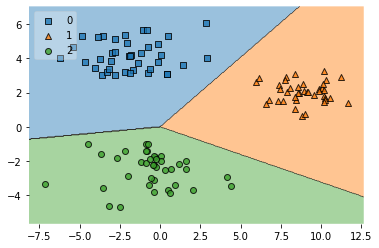

In [23]:
plot_decision_regions(X_train, y_train, clf=irls, legend=2)

In [26]:
least_squares = LeastSquares(K=nclasses)
least_squares.fit(X_train, y_train)
print("The weights are:\n", least_squares.Wml)

The weights are:
 [[-0.03973394  0.09163179  0.00441572]
 [ 0.15567397  0.0324988  -0.08580454]]


<AxesSubplot:>

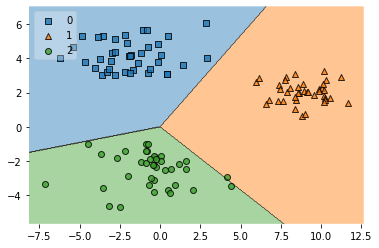

In [27]:
plot_decision_regions(X_train, y_train, clf=least_squares, legend=2)